# Report
## Mobile robotic project


In this project, the aim was to control a mobile robot in a designed environnement, containing both static obstacles that needed to be detect by a vision module and moving obstacles that needed to be avoided in a reactive way. 
In our case, we chose the following environment:
A thymio and some black obstacles are placed in a one meter by one meter white square, delimited by colorfull corners (from top left to bottom right: green, yellow, red, and blue). 
The robot is covered by an assymetric magenta shape, and the aim is a cyan star. 
The new obstacles are detected by the proximity sensor, and can by of any shape [JE SUIS PAS SUR DE çA]

In [1]:
import cv2 #read video and images
import numpy as np
from skimage import measure,exposure
from scipy import linalg, ndimage
import math
import sys
from matplotlib import pyplot as plt
from Functions import Vision as v

## Vision
For the vision part of this project, a class was created to compute and store all of the following elements:
* The geometric transform applied to the image
* The preprocessing parameters
* The preprocessed and transformed image that will be used 
* The positions and shapes of the obstacles
* The position of the robot, its orientation and its direction
* The position of the aim
The following section will detail how these were implemented.

### Preprocessing
The first step in any vision task is to preprocess the image. In our case, we wanted a fonction that was fast and that could be used on several different cameras, as we all used different phones to film the setup. As the white map could be placed on several different background and with several different illuminations, a semi-automatic control of the parameter proved to be usefull. The following code shows how we preprocessed the image, including the following steps:
* Resize the image: This allows us to use several different cameras, and to limit the time all the other image processing step takes by limiting the resolution to a resonnable amount
* Rescaling intensity: This steps allows to scale the intensity of the image between two given value. For example, if the image is rescaled between 10 and 100, this means that any intensity below 10 will be set to 0, any intensity above 100 will be set to 255, and all the values in between will be stretched.
* The image is then converted from BGR to HSV, as it is way better for color filtering
* The image is converted to UMat, to allow GPU calculation



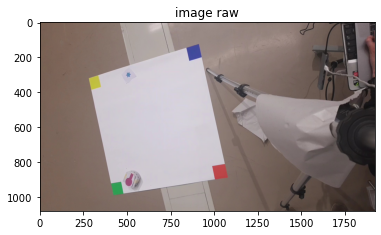

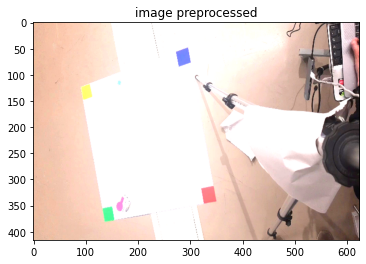

In [8]:
img = cv2.imread('sample_pictures/sample.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title('image raw')
plt.show()
imgprep = v.preprocess(img,(10,128)).get()

imgprep_rgb = cv2.cvtColor(imgprep, cv2.COLOR_HSV2RGB)
plt.imshow(imgprep_rgb)
plt.title('image preprocessed')
plt.show()

### Setting the parameters
As said before, the background and luminosity can change. To avoid any problem, the min and max luminosity can be changed at the begining of the program by activating a flag, otherwise, default values are calulated as being the 10th adn 90th percentiles of the image.

In [16]:
setextval = True
valext = np.percentile(img, (10, 90)).astype(int) #default value
if setextval:
    valext = v.adjustlum(img,valext)
print("The selectect min and max are "+str(valext))

Select the equalization, then press v to validate
The selectect min and max are (50, 130)


With some backgrounds, even a perfect preprocessing cannot avoid selecting 